# Uncovering the “riddle of femininity” in osteoarthritis: a systematic review of current menopausal animal models and mathematical model of the timing hypothesis

### Appendix S3: Python Jupyter Notebook for Timing Model Development

This notebook contains the code that was used to generated the data and figures used in the manuscript.

### Import raw data into python

The below section of code pulls the raw data from a .csv file that was generated from our systematic review of the literature. Detailed information on how the standardized mean differences (SMD) and other pertinent values were determined is available in Table S6. This analysis included a total 9 unique studies, with 16 different combinations of time points and dosages.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


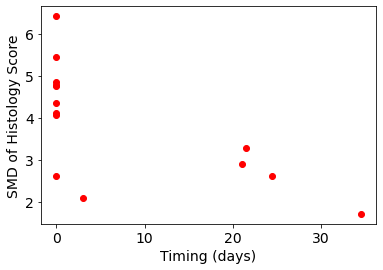

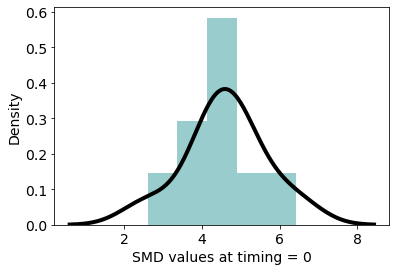

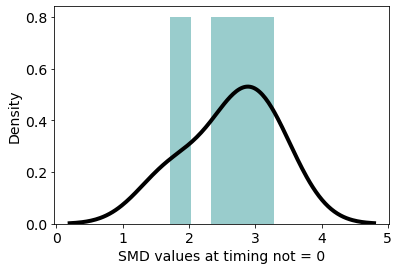

In [1]:
# Import packages into Python
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns 
import os
import random
import statsmodels.api as sm

#  Import data from CSV
dat = pd.read_csv('HistologyDatav6.csv', index_col = None)
df = pd.DataFrame(dat, columns= ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool'])
dat.columns = ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']
dataMat = dat.loc[:, ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']]
pmid = dataMat.PMID
dosage = dataMat.Dosage
timing = dataMat.Timing
SMD = dataMat.SMD
SDpool = dataMat.Sdpool

# Plot raw data for visualization
plt.rcParams.update({'font.size': 14})
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")
plt.plot(timing, SMD, 'ro')
plt.savefig('timing.png', dpi=300, bbox_inches='tight');

# Plot density plots of data from time point zero 

plt.subplots()
plt.rcParams.update({'font.size': 14})
sns.kdeplot(SMD[0:9])
sns.distplot(x = SMD[0:9],  bins = 5 , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 4 , color = 'black'))
plt.xlabel("SMD values at timing = 0");
plt.ylabel("Density");

# Plot density plots of data from non-zero time points

plt.subplots()
plt.rcParams.update({'font.size': 14})
sns.kdeplot(SMD[10:16])
sns.distplot(x = SMD[10:16],  bins = 5 , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 4 , color = 'black'))
plt.xlabel("SMD values at timing not = 0");
plt.ylabel("Density");

### Defining model of interest and RMSE for timing data


A model was developed based on best trendline fitting in Excel. Best trendline fitting was defined as having the highest $R^{2}$ value that's values fit within the data (i.e. the model does not suggest ranges that are outside that of the data). Specifically, the below second order polynomial was found to be the best fit based on Excel trendline fitting.

\begin{align}
& SMD = 0.0007t^{2} - 0.0968t + 4.3947\\
& R^{2} = 0.5534\\
\end{align}

To simulate this model, we generated the derivative of this equation and specific parameters for our model to find.

\begin{align}
& \dot{SMD} = at + b\\
\end{align}

The constraints placed on our model were similar to that above: namely, the model had to fall within 3 standard deviations of the SMD at each known data point. 

In [2]:
# set up model
def dSMDdt(SMD, t, a, b):
    dSMDdt = a*t + b
    return dSMDdt

# define RMSE 
def RMSE(params):
    a, b = params;
    ODE_output = odeint(dSMDdt, SMD_0, timesteps, args = (a,b));
    err = ExpData -ODE_output
    SSE = np.sum(err**2)
    RMSE = np.sqrt(SSE)
    return RMSE


### Simulating the timing model

The next section of code simulates the above defined model 20,000 times. Within each simulation, a random data point is chosen from each study that is within a normal distribution based on each study's SMD and pooled standard deviation. Parameter values and RMSE are only kept if the model falls within the data limits, as inidicated in the previous section.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

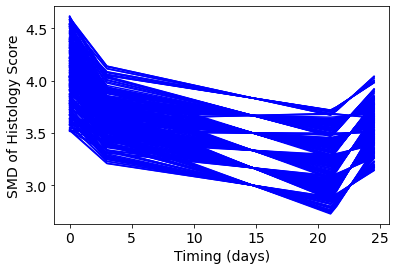

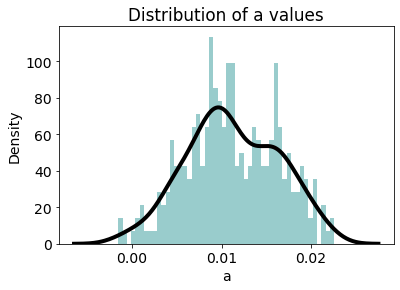

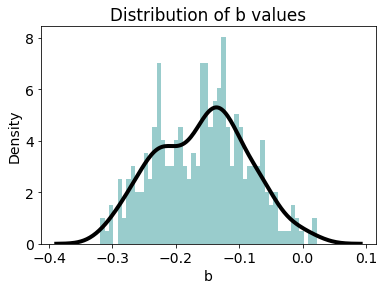

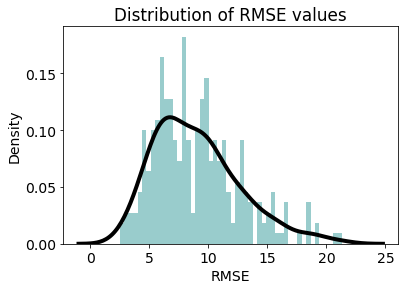

In [5]:
# Defines the size of the vector
sizeSMD = len(SMD)
# Defines the index start point
index = 0
# Based on the size of the vector, and the number of 0 data points, figures out index size of non-zero values
for q in np.arange(0,sizeSMD,1):
    if timing[q] > 0:
        index = index + 1
index = index + 1

# Pulls time points based on timing data available (correcting for multiple zero points)
startTime = sizeSMD - index-1
endTime = sizeSMD -1 
timesteps = timing[startTime:endTime]
# Sets initial guesses based on trendline model from Excel
p0 = [0.0007, -0.0968]
# sets counter equal to zero
f = 0
# Number of simulations to run
numIt = 20000
# Number of values to be generated for each normal distribution based on the SMD and SD pooled from each study
nVal = 1000
# Generates a vector to store the different values of a, b, and RMSE generated by the simulation
a = np.zeros(numIt) - 10000
b = np.zeros(numIt) - 10000
RMSE_val = np.zeros(numIt) - 10000
# Generates a random choice vector so that the starting point can be altered based on the data that are available
randChoiceEnd = startTime + 1
randChoice = np.arange(0,randChoiceEnd,1)
# generates a figure for the simulations to be plotted on
plt.figure() 
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")
plt.rcParams.update({'font.size': 14})

# Simulates using different initial conditions
for j in np.arange(1,numIt,1):
    # Generates vector to store data for this particular simulation
    ExpData = np.arange(0,index,1)
    # Choices a random value to start simulation with from the various timing =0 studies
    randVal = random.choice(randChoice)
    # Generates a normal distribution from the random starting point that was chosen 
    RandGen = np.random.normal(SMD[randVal], SDpool[randVal], nVal)
    # Randomly chooses a value from the normal distirbution of the random start point
    randCho = random.choice(RandGen)
    # Sets initial condition equal to chosen value
    SMD_0 = randCho
    ExpData[0] = SMD_0
    # Sets iteration markers
    m = randChoiceEnd
    q = 1
    # Generates the values for the non zero time points for the simulation
    for x in np.arange(1,index,1):
        # Generates a normal distribution based on the SMD and SD from that specific data point
        RandGen = np.random.normal(SMD[m], SDpool[m], nVal)
        # Randomly pulls a value from that normal distirbution to input into model
        randCho = random.choice(RandGen)
        # Assigns random value into experimental data
        ExpData[q] = randCho
        # Iterates m and q
        m = m + 1
        q = q + 1
    
    
    # Minimizes RMSE using simulated data
    sol = minimize(RMSE, p0);
    # Enters generated value into a temporary place holder for a and b
    a_temp = sol.x[0]
    b_temp = sol.x[1]
    # Generates model data based on a and b values
    modelData = odeint(dSMDdt, SMD_0, timesteps, args = (a_temp,b_temp));
    # Checks to make sure model falls within range of data. 
    # If model is within the range of SMD+/-3*SD, it is kept and deemed an appropriate fit. (99% CI)
    # If the model is not within the 99% CI, it is considered an inappropriate fit and not kept
    
    # Sets counter = 0
    count = 0
    #Checks to see if model fits within boundary condition for the initial starting point that was randomly chosen above
    if modelData[0] <= (SMD[randVal]+3*SDpool[randVal]):
        if modelData[0] >= (SMD[randVal]-3*SDpool[randVal]):
            count = 1
    # Checks to see if model fits within the 3SDs of the non-zero time points
    for x in np.arange(1,len(modelData),1):
        if modelData[x] <= (SMD[startTime+x]+3*SDpool[startTime+x]):
            if modelData[x] >= (SMD[startTime+x]-3*SDpool[startTime+x]):
                count = count + 1
                        
    # If all points fit within the model parameter, then the a and b values are recorded
    if count >= (len(modelData)):          
        # Stores a, b, and RMSE value 
        a[f] = a_temp;
        b[f] = b_temp;
        RMSE_val[f] = sol.fun
        # Increases counter
        f = f+1
        # Plots simulation
        plt.plot(timesteps, modelData, 'b-')
#Saves final plot as figure
plt.savefig('timingSimModels.png', dpi=300, bbox_inches='tight');

# Keeps only the values of a, b, and RMSE where a value was added
j = 0
while a[j] > -10000:
    j = j +1
a_final = a[0:j]
b_final = b[0:j]
RMSE_final = RMSE_val[0:j]
    
# Plots generated a values
plt.subplots()
plt.rcParams.update({'font.size': 14})
sns.kdeplot(a_final)
sns.distplot(x = a_final,  bins = 50 , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 4 , color = 'black'))
plt.title(f"Distribution of a values")
plt.xlabel("a");
plt.ylabel("Density");
plt.savefig('timingSimAValues_den.png', dpi=300, bbox_inches='tight');

# Plots generated b values
plt.subplots()
plt.rcParams.update({'font.size': 14})
sns.kdeplot(b_final)
sns.distplot(x = b_final,  bins = 50 , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 4 , color = 'black'))
plt.title(f"Distribution of b values")
plt.xlabel("b");
plt.ylabel("Density");
plt.savefig('timingSimBValues_den.png', dpi=300, bbox_inches='tight');

# Plots generated RMSE values
plt.subplots()
plt.rcParams.update({'font.size': 14})
sns.kdeplot(RMSE_final)
sns.distplot(x = RMSE_final,  bins = 50 , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 4 , color = 'black'))
plt.title(f"Distribution of RMSE values")
plt.xlabel("RMSE");
plt.ylabel("Density");
plt.savefig('timingSimRMSEValues_den.png', dpi=300, bbox_inches='tight');




### Calculating a p-value for the timing simulation

The below section of code calculates the p-value. Our null hypothesis is that the parameter values are equal to zero, and the alternate hypothesis is that they are not equal to zero. Based on our initial trendline fit from Excel, we think a should be positive and b should be negative. For a, any values equal to zero or lower are deemed "zero values". For b, any values greater than or equal to zero are deemed "zero values."

In [6]:
import statistics

# Calculate the p value for a 
f = 0
n = 0
sizeA = len(a_final)-1
for j in np.arange(1,sizeA,1):
    if a_final[f] >= 0:
        n = n +1
    f = f+1

a_pvalue = (sizeA-n)/sizeA

# Calculate p value for b
g = 0
m= 0
sizeB = len(b_final)-1
for k in np.arange(1,sizeB,1):
    if b_final[g] >= 0:
        m = m+1
    g = g+1
    
b_pvalue =(m)/sizeB

# Print both p values
print('The p-value for the a parameter is %.4f.' % a_pvalue)
print('The p-value for the b parameter is %.4f.' % b_pvalue)
# Print the average value for both paramters
a_avg = sum(a_final)/len(a_final)
b_avg = sum(b_final)/len(b_final)
a_std = statistics.stdev(a_final)
b_std = statistics.stdev(b_final)
print('The average value for the a parameter is %.4f.' % a_avg)
print('The average value for the b parameter is %.4f.' % b_avg)
print('The std value for the a parameter is %.4f.' % a_std)
print('The std value for the b parameter is %.4f.' % b_std)

The p-value for the a parameter is 0.0137.
The p-value for the b parameter is 0.0103.
The average value for the a parameter is 0.0112.
The average value for the b parameter is -0.1586.
The std value for the a parameter is 0.0051.
The std value for the b parameter is 0.0722.


### Simulating Timing Model as a Linear fit

To explore other model types and not over fit the data, we also ran our simulation as a linear model here. 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The p-value for the b parameter is 0.0000.
The average value for the b parameter is -0.0352.
The std value for the b parameter is 0.0183.


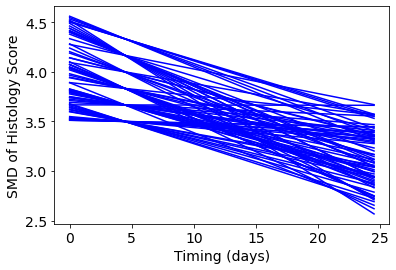

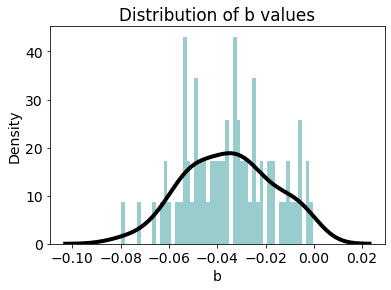

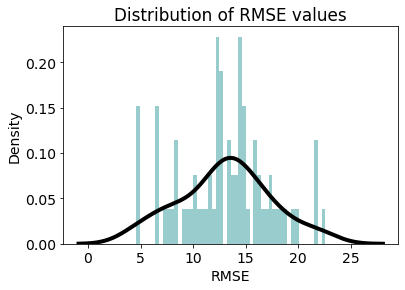

In [8]:
# Defines the size of the vector
sizeSMD = len(SMD)
# Defines the index size
index = 0
# Based on the size of the vector, and the number of 0 data points, figures out index size
for q in np.arange(0,sizeSMD,1):
    if timing[q] > 0:
        index = index + 1
index = index + 1

# Pulls time points based on timing data available 
startTime = sizeSMD - index-1
endTime = sizeSMD -1 
timesteps = timing[startTime:endTime]
# Sets initial guesses based on trendline model for linear equationfrom Excel
p0 = [0, -0.0756]
# sets counter equal to zero
f = 0
# Number of simulations to run
numIt = 20000
# Number of values to be generated for each data point
nVal = 100
# Generates a vector of the different values of a, b, and RMSE generated by the simulation
a = np.zeros(numIt) - 10000
b = np.zeros(numIt) - 10000
RMSE_val = np.zeros(numIt) - 10000
# Generates a random choice vector so that the starting point can be altered based on the data that are available
randChoiceEnd = startTime + 1
randChoice = np.arange(0,randChoiceEnd,1)
# generates a figure for the simulations to be plotted on
plt.figure() 
plt.rcParams.update({'font.size': 14})
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")

# Simulates using different initial conditions
for j in np.arange(1,numIt,1):
    # Generates ExpData vectora
    ExpData = np.arange(0,index,1)
    # Choices a random value to start simulation with
    randVal = random.choice(randChoice)
    # Generates a normal distribution from the random starting point that was chosen 
    RandGen = np.random.normal(SMD[randVal], SDpool[randVal], nVal)
    # Randomly chooses a value from the normal distirbution of the random start point
    randCho = random.choice(RandGen)
    # Sets initial condition equal to chosen value
    SMD_0 = randCho
    ExpData[0] = SMD_0
    # Sets iteration markers
    m = randChoiceEnd
    q = 1
    
    for x in np.arange(1,index,1):
        # Generates a normal distribution based on the SMD and SD from that specific data point
        RandGen = np.random.normal(SMD[m], SDpool[m], nVal)
        # Randomly pulls a value from that normal distirbution to input into model
        randCho = random.choice(RandGen)
        # Assigns random value into experimental data
        ExpData[q] = randCho
        # Iterates m and q
        m = m + 1
        q = q + 1
    
    
    # Minimizes RMSE uses initial data
    sol = minimize(RMSE, p0);
    # Enters generated value into the vector to track all possible a and b values from simulation
    a_temp = 0
    b_temp = sol.x[1]
    # Generates model data based on a and b values
    modelData = odeint(dSMDdt, SMD_0, timesteps, args = (a_temp,b_temp));
    # Checks to make sure model falls within range of data. 
    # If model is within the range of SMD+/-3*SD, it is kept and deemed an appropriate fit. (99% CI)
    # If the model is not within the 99% CI, it is considered an inappropriate fit and not kept
    
    # Sets counter = 0
    count = 0
    #Checks to see if model fits within boundary condition for the initial starting point that was randomly chosen above
    if modelData[0] <= (SMD[randVal]+3*SDpool[randVal]):
        if modelData[0] >= (SMD[randVal]-3*SDpool[randVal]):
            count = 1
    # loops through the maining data points to check to make sure each point meets the boundary condition
    for q in np.arange(1,len(modelData),1):
        if modelData[q] <= (SMD[startTime+q]+3*SDpool[startTime+q]):
            if modelData[q] >= (SMD[startTime+q]-3*SDpool[startTime+q]):
                count = count + 1
                        
    # If all points fit within the model parameter, then the value is recorded
    if count >= (len(modelData)):          
        # Stores a, b, and RMSE value 
        b[f] = b_temp;
        RMSE_val[f] = sol.fun
        # Increases counter
        f = f+1
        # Plots simulation
        plt.plot(timesteps, modelData, 'b-')

# Saves figure
plt.savefig('timingSimModels_linear.png', dpi=300, bbox_inches='tight');
# Keeps only the values of a, b, and RMSE where a value was added
j = 0
while b[j] > -10000:
    j = j +1
b_final = b[0:j]
RMSE_final = RMSE_val[0:j]
    

# Plots generated b values
plt.subplots()
plt.rcParams.update({'font.size': 14})
sns.kdeplot(b_final)
sns.distplot(x = b_final,  bins = 50 , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 4 , color = 'black'))
plt.title(f"Distribution of b values")
plt.xlabel("b");
plt.ylabel("Density");
plt.savefig('timingSimBValuesLinear_den.png', dpi=300, bbox_inches='tight');

# Plots generated RMSE values
plt.subplots()
plt.rcParams.update({'font.size': 14})
sns.kdeplot(RMSE_final)
sns.distplot(x = RMSE_final,  bins = 50 , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 4 , color = 'black'))
plt.title(f"Distribution of RMSE values")
plt.xlabel("RMSE");
plt.ylabel("Density");
plt.savefig('timingSimRMSEValuesLinear_den.png', dpi=300, bbox_inches='tight');


# Calculates p value for b
g = 0
m= 0
sizeB = len(b_final)-1
for k in np.arange(1,sizeB,1):
    if b_final[g] >= 0:
        m = m+1
    g = g+1
    
b_pvalue =(m)/sizeB

# Print both p values
print('The p-value for the b parameter is %.4f.' % b_pvalue)
# Print the average value for both paramters
b_avg = sum(b_final)/len(b_final)
print('The average value for the b parameter is %.4f.' % b_avg)

b_std = statistics.stdev(b_final)
print('The std value for the b parameter is %.4f.' % b_std)


### Plotting RMSE versus a and b

To visualize the effect of a and b changing on RMSE, we plotted the two versus RMSE. We saw that the value of a strongly correlated with the RMSE function, while the value of b, had a very weak to non-consequential relationship with RMSE. As such, we kept with the quadratic model for the remainder of the sensitivity analyses, since a seems to be playing a consequential role in the analyses.

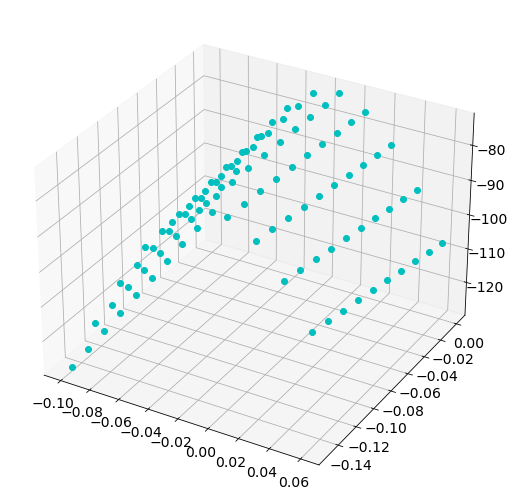

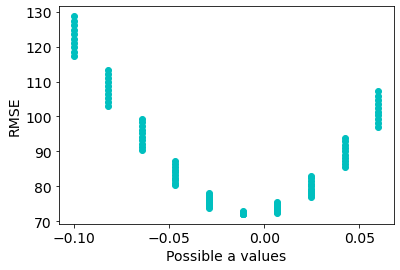

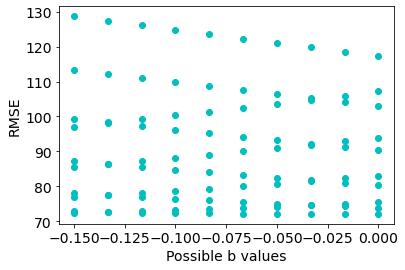

In [10]:
import matplotlib.colors as mcolors

# sets up model
def dSMDdt(SMD, t, a, b):
    dSMDdt = a*t + b
    return dSMDdt

# defines RMSE 
def RMSE(a,b):
    ODE_output = odeint(dSMDdt, SMD_0, timesteps, args = (a,b));
    err = ExpData -ODE_output
    SSE = np.sum(err**2)
    RMSE = np.sqrt(SSE)
    return RMSE

# Creates vectors of possible a and b values based on above simulations
a_poss = np.linspace(-0.1,0.06,10)
b_poss = np.linspace(-0.15,0,10)

# Generates a 3 D figure for values to be plotted on
fig = plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size': 14})
ax = plt.axes(projection='3d')

# Calculates RMSE for each possible a and b value
for a in a_poss:
    for b in b_poss:
        RMSE_val = RMSE(a,b)
        ax.plot3D(a,b, -RMSE_val, 'co')

# Labels axes        
plt.savefig('RMSE_A_BValues_3D.png', dpi=300, bbox_inches='tight');

# Generates a 2D figure for a versus RMSE to be plotted for easier visualization
fig = plt.figure()
plt.rcParams.update({'font.size': 14})
for a in a_poss:
    for b in b_poss:
        RMSE_val = RMSE(a,b)
        plt.plot(a, RMSE_val, 'co')

plt.xlabel("Possible a values")
plt.ylabel("RMSE")
plt.savefig('RMSE_A_Values.png', dpi=300, bbox_inches='tight');

# Generates a 2D figure for b versus RMSE to be plotted for easier visualization
fig = plt.figure()
plt.rcParams.update({'font.size': 14})
for a in a_poss:
    for b in b_poss:
        RMSE_val = RMSE(a,b)
        plt.plot(b, RMSE_val, 'co')

plt.xlabel("Possible b values")
plt.ylabel("RMSE")
plt.savefig('RMSE_B_Values.png', dpi=300, bbox_inches='tight');


### Sensitivity Analysis for Timing Model

The next section of code performs sensitivity analyses on various aspects of the model. Firstly, we checked how much perturbations in a and b affect model outcome variables. We observed that the model is more accurate near t = 0, which makes sense given there are more data points there, and loses accuracy at time points further away from t =0. At worst though, with 20% error in a and b, there is approximately 1.5 units of error within the SMD value.

When we perform our simulations, we noticed that there were three studies with smaller standard deviations that seemed to be playing a large role in driving the model. To check how each of these individual studies affects the model behavior, we repeated the analyses with each of these studies removed.

Given that we have variation in the samples used in this model, we also performed sensitivity analyses based on the species and joint. Specifically, two sensitivity analyses were performed: one using only the studies that used mice (N = 10, from 7 unique studies) and one using only studies that used knees (N = 13, from 6 unique studies). We did not do a sensitivity analysis with rats because there was only one non-zero point, and we did not do a sensivity analysis with hands because there was no zero point.

#### Sensitivity of values a and b

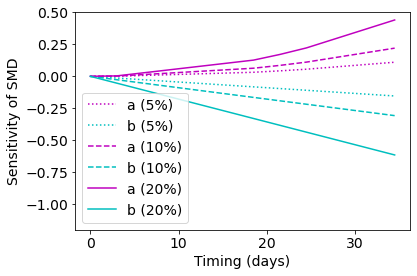

In [12]:

#  Import data from CSV
dat = pd.read_csv('HistologyData.csv', index_col = None)
df = pd.DataFrame(dat, columns= ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool'])
dat.columns = ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']
dataMat = dat.loc[:, ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']]
pmid = dataMat.PMID
dosage = dataMat.Dosage
timing = dataMat.Timing
SMD = dataMat.SMD
SDpool = dataMat.Sdpool

# Defines the size of the vector
sizeSMD = len(SMD)
# Defines the index size
index = 0
# Based on the size of the vector, and the number of 0 data points, figures out index size
for q in np.arange(0,sizeSMD,1):
    if timing[q] > 0:
        index = index + 1
index = index + 1

# Pulls time points based on timing data available 
startTime = sizeSMD - index-1
endTime = sizeSMD -1 
timesteps = timing[startTime:endTime]

# Average start point
lastZeroVal = startTime +1
SMD_i0 = sum(SMD[0:lastZeroVal])/len(SMD[0:lastZeroVal])
# Set average a and b values as determined in previous code
a_avg = 0.0037
b_avg = -0.0891

# Calculates the baseline SMD if the average values are correct
SMD_0 = odeint(dSMDdt, SMD_i0, timesteps, args = (a_avg,b_avg))

# Calculates SMD if a is altered by 5%
SMD_a = odeint(dSMDdt, SMD_i0, timesteps, args = (a_avg*1.05,b_avg))
# Determined the perturbation in SMD based on error caused by a being 10% changed
SMD_a0 = SMD_a - SMD_0
plt.plot(timesteps, SMD_a0,'m:', label = "a (5%)");
# Calculates SMD if b is altered by 5%
SMD_b = odeint(dSMDdt, SMD_i0, timesteps, args = (a_avg,b_avg*1.05))
# Determined the perturbation in SMD based on error caused by a being 5% changed
SMD_b0 = SMD_b - SMD_0
plt.plot(timesteps, SMD_b0,'c:', label = "b (5%)");

# Calculates SMD if a is altered by 10%
SMD_a = odeint(dSMDdt, SMD_i0, timesteps, args = (a_avg*1.1,b_avg))
# Determined the perturbation in SMD based on error caused by a being 10% changed
SMD_a0 = SMD_a - SMD_0
plt.plot(timesteps, SMD_a0,'m--', label = "a (10%)");
# Calculates SMD if b is altered by 10%
SMD_b = odeint(dSMDdt, SMD_i0, timesteps, args = (a_avg,b_avg*1.1))
# Determined the perturbation in SMD based on error caused by a being 10% changed
SMD_b0 = SMD_b - SMD_0
plt.plot(timesteps, SMD_b0,'c--', label = "b (10%)");

# Calculates SMD if a is altered by 20%
SMD_a = odeint(dSMDdt, SMD_i0, timesteps, args = (a_avg*1.2,b_avg))
# Determined the perturbation in SMD based on error caused by a being 20% changed
SMD_a0 = SMD_a - SMD_0
plt.plot(timesteps, SMD_a0,'m', label = "a (20%)");
# Calculates SMD if b is altered by 20%
SMD_b = odeint(dSMDdt, SMD_i0, timesteps, args = (a_avg,b_avg*1.2))
# Determined the perturbation in SMD based on error caused by a being 20% changed
SMD_b0 = SMD_b - SMD_0
plt.plot(timesteps, SMD_b0,'c', label = "b (20%)");

# Labels the plot
plt.rcParams.update({'font.size': 14})
plt.xlabel("Timing (days)")
plt.ylabel("Sensitivity of SMD")
plt.ylim([-1.2,0.5])
plt.legend(loc='lower left')
plt.savefig('sensitivityAB.png', dpi=300, bbox_inches='tight');


#### Sensitivity analysis removing timepoint day = 21 (PMID = 16871544)

The p-value for the a parameter is 0.0175.
The p-value for the b parameter is 0.0132.
The average value for the a parameter is 0.0120.
The average value for the b parameter is -0.1666.


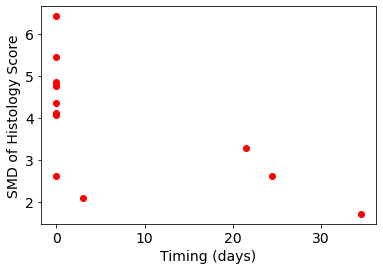

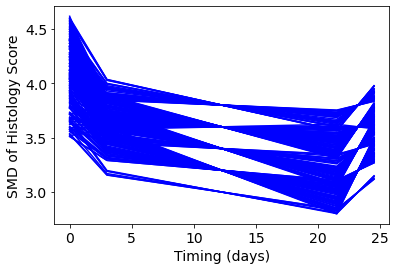

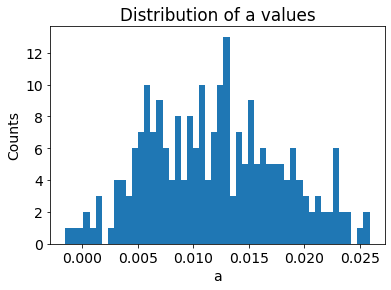

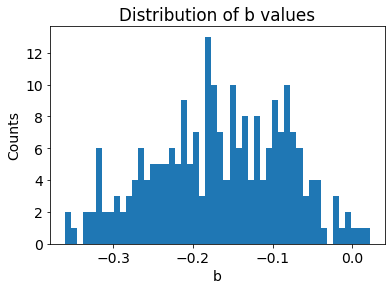

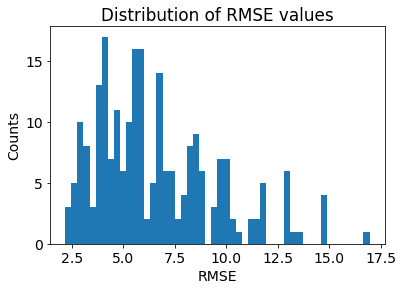

In [19]:
# Import packages into Python
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns 
import os
import random
import statsmodels.api as sm


#  Import data from CSV
dat = pd.read_csv('HistologyData21.csv', index_col = None)
df = pd.DataFrame(dat, columns= ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool'])
dat.columns = ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']
dataMat = dat.loc[:, ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']]
pmid = dataMat.PMID
dosage = dataMat.Dosage
timing = dataMat.Timing
SMD = dataMat.SMD
SDpool = dataMat.Sdpool


# Plot raw data
plt.rcParams.update({'font.size': 14});
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")
plt.plot(timing, SMD, 'ro')

# set up model
def dSMDdt(SMD, t, a, b):
    dSMDdt = a*t + b
    return dSMDdt

# define RMSE 
def RMSE(params):
    a, b = params;
    ODE_output = odeint(dSMDdt, SMD_0, timesteps, args = (a,b));
    err = ExpData -ODE_output
    SSE = np.sum(err**2)
    RMSE = np.sqrt(SSE)
    return RMSE


# Defines the size of the vector
sizeSMD = len(SMD)
# Defines the index size
index = 0
# Based on the size of the vector, and the number of 0 data points, figures out index size
for q in np.arange(0,sizeSMD,1):
    if timing[q] > 0:
        index = index + 1
index = index + 1

# Pulls time points based on timing data available 
startTime = sizeSMD - index-1
endTime = sizeSMD -1 
timesteps = timing[startTime:endTime]
# Sets initial guesses based on trendline model from Excel
p0 = [0.0004, -0.0756]
# sets counter equal to zero
f = 0
# Number of simulations to run
numIt = 20000
# Number of values to be generated for each data point
nVal = 100
# Generates a vector of the different values of a, b, and RMSE generated by the simulation
a = np.zeros(numIt) - 10000
b = np.zeros(numIt) - 10000
RMSE_val = np.zeros(numIt) - 10000
# Generates a random choice vector so that the starting point can be altered based on the data that are available
randChoiceEnd = startTime + 1
randChoice = np.arange(0,randChoiceEnd,1)
# generates a figure for the simulations to be plotted on
plt.figure() 
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")
plt.rcParams.update({'font.size': 14})

# Simulates using different initial conditions
for j in np.arange(1,numIt,1):
    # Generates ExpData vector
    ExpData = np.arange(0,index,1)
    # Choices a random value to start simulation with
    randVal = random.choice(randChoice)
    # Generates a normal distribution from the random starting point that was chosen 
    RandGen = np.random.normal(SMD[randVal], SDpool[randVal], nVal)
    # Randomly chooses a value from the normal distirbution of the random start point
    randCho = random.choice(RandGen)
    # Sets initial condition equal to chosen value
    SMD_0 = randCho
    ExpData[0] = SMD_0
    # Sets iteration markers
    m = randChoiceEnd
    q = 1
    
    for x in np.arange(1,index,1):
        # Generates a normal distribution based on the SMD and SD from that specific data point
        RandGen = np.random.normal(SMD[m], SDpool[m], nVal)
        # Randomly pulls a value from that normal distirbution to input into model
        randCho = random.choice(RandGen)
        # Assigns random value into experimental data
        ExpData[q] = randCho
        # Iterates m and q
        m = m + 1
        q = q + 1
    
    
    # Minimizes RMSE uses initial data
    sol = minimize(RMSE, p0);
    # Enters generated value into the vector to track all possible a and b values from simulation
    a_temp = sol.x[0]
    b_temp = sol.x[1]
    # Generates model data based on a and b values
    modelData = odeint(dSMDdt, SMD_0, timesteps, args = (a_temp,b_temp));
    # Checks to make sure model falls within range of data. 
    # If model is within the range of SMD+/-3*SD, it is kept and deemed an appropriate fit. (99% CI)
    # If the model is not within the 99% CI, it is considered an inappropriate fit and not kept
    
    # Sets counter = 0
    count = 0
    #Checks to see if model fits within boundary condition for the initial starting point that was randomly chosen above
    if modelData[0] <= (SMD[randVal]+3*SDpool[randVal]):
        if modelData[0] >= (SMD[randVal]-3*SDpool[randVal]):
            count = 1
    # If initial condition is okay, then it will loop through the maining data points to check to make sure each point meets the boundary condition
    for x in np.arange(1,len(modelData),1):
        if modelData[x] <= (SMD[startTime+x]+3*SDpool[startTime+x]):
            if modelData[x] >= (SMD[startTime+x]-3*SDpool[startTime+x]):
                count = count + 1
                        
    # If all points fit within the model parameter, then the value is recorded
    if count >= (len(modelData)):          
        # Stores a, b, and RMSE value 
        a[f] = a_temp;
        b[f] = b_temp;
        RMSE_val[f] = sol.fun
        # Increases counter
        f = f+1
        # Plots simulation
        plt.plot(timesteps, modelData, 'b-')

#Saves final plot as figure
plt.savefig('timingSimModels185.png', dpi=300, bbox_inches='tight');
# Keeps only the values of a, b, and RMSE where a value was added
j = 0
while a[j] > -10000:
    j = j +1
a_final = a[0:j]
b_final = b[0:j]
RMSE_final = RMSE_val[0:j]
    
# Plots generated a values
plt.subplots()
plt.hist(a_final, bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of a values")
plt.xlabel("a")
plt.ylabel("Counts")
plt.savefig('timingSimAValue185.png', dpi=300, bbox_inches='tight');

# Plots generated b values
plt.subplots()
plt.hist(b_final,bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of b values")
plt.xlabel("b")
plt.ylabel("Counts")
plt.savefig('timingSimBValue185.png', dpi=300, bbox_inches='tight');

# Plots generated RMSE values
plt.subplots()
plt.hist(RMSE_final,bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of RMSE values")
plt.xlabel("RMSE")
plt.ylabel("Counts")
plt.savefig('timingSimRMSEValue185.png', dpi=300, bbox_inches='tight');

# Calculate the p value for a 
f = 0
n = 0
sizeA = len(a_final)-1
for j in np.arange(1,sizeA,1):
    if a_final[f] >= 0:
        n = n +1
    f = f+1

a_pvalue = (sizeA-n)/sizeA

# Calculate p value for b
g = 0
m= 0
sizeB = len(b_final)-1
for k in np.arange(1,sizeB,1):
    if b_final[g] >= 0:
        m = m+1
    g = g+1
    
b_pvalue =(m)/sizeB

# Print both p values
print('The p-value for the a parameter is %.4f.' % a_pvalue)
print('The p-value for the b parameter is %.4f.' % b_pvalue)
# Print the average value for both paramters
a_avg = sum(a_final)/len(a_final)
b_avg = sum(b_final)/len(b_final)
print('The average value for the a parameter is %.4f.' % a_avg)
print('The average value for the b parameter is %.4f.' % b_avg)




#### Sensitivity analysis removing timepoint day = 21.5 (PMID = 20112355)

The p-value for the a parameter is 0.0972.
The p-value for the b parameter is 0.0950.
The average value for the a parameter is 0.0160.
The average value for the b parameter is -0.2258.


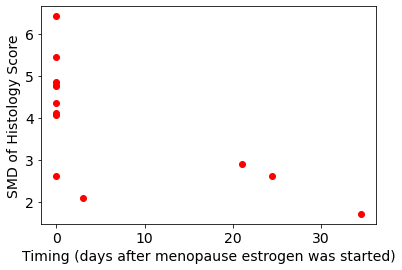

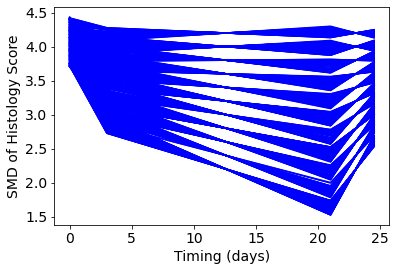

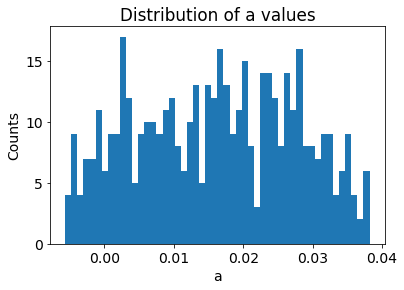

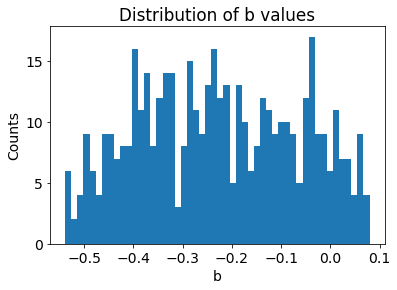

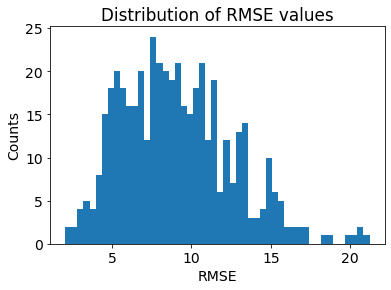

In [20]:
# Import packages into Python
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns 
import os
import random
import statsmodels.api as sm

#  Import data from CSV
dat = pd.read_csv('HistologyData21.5.csv', index_col = None)
df = pd.DataFrame(dat, columns= ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool'])
dat.columns = ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']
dataMat = dat.loc[:, ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']]
pmid = dataMat.PMID
dosage = dataMat.Dosage
timing = dataMat.Timing
SMD = dataMat.SMD
SDpool = dataMat.Sdpool


# Plot raw data
plt.rcParams.update({'font.size': 14})
plt.xlabel("Timing (days after menopause estrogen was started)")
plt.ylabel("SMD of Histology Score")
plt.plot(timing, SMD, 'ro')

# set up model
def dSMDdt(SMD, t, a, b):
    dSMDdt = a*t + b
    return dSMDdt

# define RMSE 
def RMSE(params):
    a, b = params;
    ODE_output = odeint(dSMDdt, SMD_0, timesteps, args = (a,b));
    err = ExpData -ODE_output
    SSE = np.sum(err**2)
    RMSE = np.sqrt(SSE)
    return RMSE


# Defines the size of the vector
sizeSMD = len(SMD)
# Defines the index size
index = 0
# Based on the size of the vector, and the number of 0 data points, figures out index size
for q in np.arange(0,sizeSMD,1):
    if timing[q] > 0:
        index = index + 1
index = index + 1

# Pulls time points based on timing data available 
startTime = sizeSMD - index-1
endTime = sizeSMD -1 
timesteps = timing[startTime:endTime]
# Sets initial guesses based on trendline model from Excel
p0 = [0.0004, -0.0756]
# sets counter equal to zero
f = 0
# Number of simulations to run
numIt = 20000
# Number of values to be generated for each data point
nVal = 100
# Generates a vector of the different values of a, b, and RMSE generated by the simulation
a = np.zeros(numIt) - 10000
b = np.zeros(numIt) - 10000
RMSE_val = np.zeros(numIt) - 10000
# Generates a random choice vector so that the starting point can be altered based on the data that are available
randChoiceEnd = startTime + 1
randChoice = np.arange(0,randChoiceEnd,1)
# generates a figure for the simulations to be plotted on
plt.figure() 
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")
plt.rcParams.update({'font.size': 14})

# Simulates using different initial conditions
for j in np.arange(1,numIt,1):
    # Generates ExpData vector
    ExpData = np.arange(0,index,1)
    # Choices a random value to start simulation with
    randVal = random.choice(randChoice)
    # Generates a normal distribution from the random starting point that was chosen 
    RandGen = np.random.normal(SMD[randVal], SDpool[randVal], nVal)
    # Randomly chooses a value from the normal distirbution of the random start point
    randCho = random.choice(RandGen)
    # Sets initial condition equal to chosen value
    SMD_0 = randCho
    ExpData[0] = SMD_0
    # Sets iteration markers
    m = randChoiceEnd
    q = 1
    
    for x in np.arange(1,index,1):
        # Generates a normal distribution based on the SMD and SD from that specific data point
        RandGen = np.random.normal(SMD[m], SDpool[m], nVal)
        # Randomly pulls a value from that normal distirbution to input into model
        randCho = random.choice(RandGen)
        # Assigns random value into experimental data
        ExpData[q] = randCho
        # Iterates m and q
        m = m + 1
        q = q + 1
    
    
    # Minimizes RMSE uses initial data
    sol = minimize(RMSE, p0);
    # Enters generated value into the vector to track all possible a and b values from simulation
    a_temp = sol.x[0]
    b_temp = sol.x[1]
    # Generates model data based on a and b values
    modelData = odeint(dSMDdt, SMD_0, timesteps, args = (a_temp,b_temp));
    # Checks to make sure model falls within range of data. 
    # If model is within the range of SMD+/-3*SD, it is kept and deemed an appropriate fit. (99% CI)
    # If the model is not within the 99% CI, it is considered an inappropriate fit and not kept
    
    # Sets counter = 0
    count = 0
    #Checks to see if model fits within boundary condition for the initial starting point that was randomly chosen above
    if modelData[0] <= (SMD[randVal]+2*SDpool[randVal]):
        if modelData[0] >= (SMD[randVal]-2*SDpool[randVal]):
            count = 1
    # If initial condition is okay, then it will loop through the maining data points to check to make sure each point meets the boundary condition
    for x in np.arange(1,len(modelData),1):
        if modelData[x] <= (SMD[startTime+x]+2*SDpool[startTime+x]):
            if modelData[x] >= (SMD[startTime+x]-2*SDpool[startTime+x]):
                count = count + 1
                        
    # If all points fit within the model parameter, then the value is recorded
    if count >= (len(modelData)):          
        # Stores a, b, and RMSE value 
        a[f] = a_temp;
        b[f] = b_temp;
        RMSE_val[f] = sol.fun
        # Increases counter
        f = f+1
        # Plots simulation
        plt.plot(timesteps, modelData, 'b-')

# Saves model figure
plt.savefig('timingSimModels215.png', dpi=300, bbox_inches='tight');
# Keeps only the values of a, b, and RMSE where a value was added
j = 0
while a[j] > -10000:
    j = j +1
a_final = a[0:j]
b_final = b[0:j]
RMSE_final = RMSE_val[0:j]
    
# Plots generated a values
plt.subplots()
plt.hist(a_final, bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of a values")
plt.xlabel("a")
plt.ylabel("Counts")
plt.savefig('timingSimAValue215.png', dpi=300, bbox_inches='tight');

# Plots generated b values
plt.subplots()
plt.hist(b_final,bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of b values")
plt.xlabel("b")
plt.ylabel("Counts")
plt.savefig('timingSimBValue215.png', dpi=300, bbox_inches='tight');

# Plots generated RMSE values
plt.subplots()
plt.hist(RMSE_final,bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of RMSE values")
plt.xlabel("RMSE")
plt.ylabel("Counts")
plt.savefig('timingSimRMSEValue215.png', dpi=300, bbox_inches='tight');

# Calculate the p value for a 
f = 0
n = 0
sizeA = len(a_final)-1
for j in np.arange(1,sizeA,1):
    if a_final[f] >= 0:
        n = n +1
    f = f+1

a_pvalue = (sizeA-n)/sizeA

# Calculate p value for b
g = 0
m= 0
sizeB = len(b_final)-1
for k in np.arange(1,sizeB,1):
    if b_final[g] >= 0:
        m = m+1
    g = g+1
    
b_pvalue =(m)/sizeB

# Print both p values
print('The p-value for the a parameter is %.4f.' % a_pvalue)
print('The p-value for the b parameter is %.4f.' % b_pvalue)
# Print the average value for both paramters
a_avg = sum(a_final)/len(a_final)
b_avg = sum(b_final)/len(b_final)
print('The average value for the a parameter is %.4f.' % a_avg)
print('The average value for the b parameter is %.4f.' % b_avg)




#### Sensitivity Analysis - Mice Only (N = 10)

The p-value for the a parameter is 0.0112.
The p-value for the b parameter is 0.0056.
The average value for the a parameter is 0.0089.
The average value for the b parameter is -0.1337.


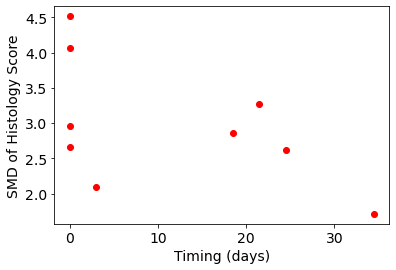

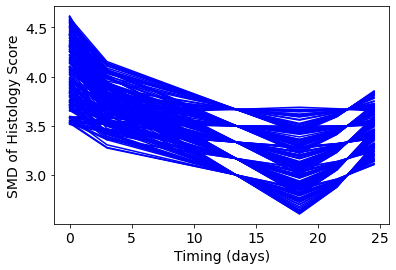

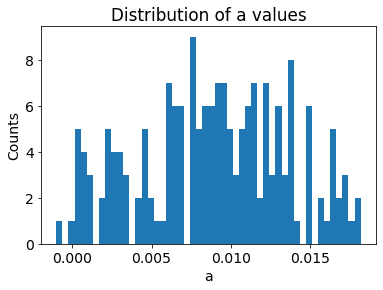

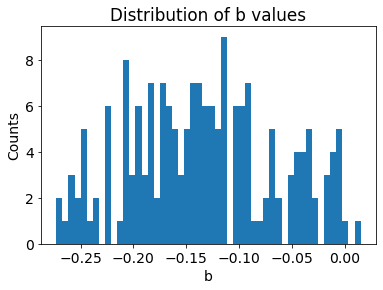

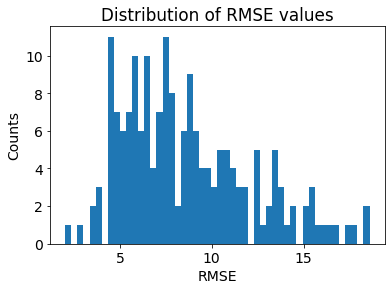

In [21]:
# Import packages into Python
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns 
import os
import random
import statsmodels.api as sm


#  Import data from CSV
dat = pd.read_csv('mouseOnly.csv', index_col = None)
df = pd.DataFrame(dat, columns= ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool'])
dat.columns = ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']
dataMat = dat.loc[:, ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']]
pmid = dataMat.PMID
dosage = dataMat.Dosage
timing = dataMat.Timing
SMD = dataMat.SMD
SDpool = dataMat.Sdpool


# Plot raw data
plt.rcParams.update({'font.size': 14})
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")
plt.plot(timing, SMD, 'ro')

# set up model
def dSMDdt(SMD, t, a, b):
    dSMDdt = a*t + b
    return dSMDdt

# define RMSE 
def RMSE(params):
    a, b = params;
    ODE_output = odeint(dSMDdt, SMD_0, timesteps, args = (a,b));
    err = ExpData -ODE_output
    SSE = np.sum(err**2)
    RMSE = np.sqrt(SSE)
    return RMSE


# Defines the size of the vector
sizeSMD = len(SMD)
# Defines the index size
index = 0
# Based on the size of the vector, and the number of 0 data points, figures out index size
for q in np.arange(0,sizeSMD,1):
    if timing[q] > 0:
        index = index + 1
index = index + 1

# Pulls time points based on timing data available 
startTime = sizeSMD - index-1
endTime = sizeSMD -1 
timesteps = timing[startTime:endTime]
# Sets initial guesses based on trendline model from Excel
p0 = [0.0004, -0.0756]
# sets counter equal to zero
f = 0
# Number of simulations to run
numIt = 20000
# Number of values to be generated for each data point
nVal = 100
# Generates a vector of the different values of a, b, and RMSE generated by the simulation
a = np.zeros(numIt) - 10000
b = np.zeros(numIt) - 10000
RMSE_val = np.zeros(numIt) - 10000
# Generates a random choice vector so that the starting point can be altered based on the data that are available
randChoiceEnd = startTime + 1
randChoice = np.arange(0,randChoiceEnd,1)
# generates a figure for the simulations to be plotted on
plt.figure() 
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")
plt.rcParams.update({'font.size': 14})

# Simulates using different initial conditions
for j in np.arange(1,numIt,1):
    # Generates ExpData vector
    ExpData = np.arange(0,index,1)
    # Choices a random value to start simulation with
    randVal = random.choice(randChoice)
    # Generates a normal distribution from the random starting point that was chosen 
    RandGen = np.random.normal(SMD[randVal], SDpool[randVal], nVal)
    # Randomly chooses a value from the normal distirbution of the random start point
    randCho = random.choice(RandGen)
    # Sets initial condition equal to chosen value
    SMD_0 = randCho
    ExpData[0] = SMD_0
    # Sets iteration markers
    m = randChoiceEnd
    q = 1
    
    for x in np.arange(1,index,1):
        # Generates a normal distribution based on the SMD and SD from that specific data point
        RandGen = np.random.normal(SMD[m], SDpool[m], nVal)
        # Randomly pulls a value from that normal distirbution to input into model
        randCho = random.choice(RandGen)
        # Assigns random value into experimental data
        ExpData[q] = randCho
        # Iterates m and q
        m = m + 1
        q = q + 1
    
    
    # Minimizes RMSE uses initial data
    sol = minimize(RMSE, p0);
    # Enters generated value into the vector to track all possible a and b values from simulation
    a_temp = sol.x[0]
    b_temp = sol.x[1]
    # Generates model data based on a and b values
    modelData = odeint(dSMDdt, SMD_0, timesteps, args = (a_temp,b_temp));
    # Checks to make sure model falls within range of data. 
    # If model is within the range of SMD+/-3*SD, it is kept and deemed an appropriate fit. (99% CI)
    # If the model is not within the 99% CI, it is considered an inappropriate fit and not kept
    
    # Sets counter = 0
    count = 0
    #Checks to see if model fits within boundary condition for the initial starting point that was randomly chosen above
    if modelData[0] <= (SMD[randVal]+3*SDpool[randVal]):
        if modelData[0] >= (SMD[randVal]-3*SDpool[randVal]):
            count = 1
    # If initial condition is okay, then it will loop through the maining data points to check to make sure each point meets the boundary condition
    for x in np.arange(1,len(modelData),1):
        if modelData[x] <= (SMD[startTime+x]+3*SDpool[startTime+x]):
            if modelData[x] >= (SMD[startTime+x]-3*SDpool[startTime+x]):
                count = count + 1
                        
    # If all points fit within the model parameter, then the value is recorded
    if count >= (len(modelData)):          
        # Stores a, b, and RMSE value 
        a[f] = a_temp;
        b[f] = b_temp;
        RMSE_val[f] = sol.fun
        # Increases counter
        f = f+1
        # Plots simulation
        plt.plot(timesteps, modelData, 'b-')
# Save figure
plt.savefig('timingSimModelMice.png', dpi=300, bbox_inches='tight');
# Keeps only the values of a, b, and RMSE where a value was added
j = 0
while a[j] > -10000:
    j = j +1
a_final = a[0:j]
b_final = b[0:j]
RMSE_final = RMSE_val[0:j]
    
# Plots generated a values
plt.subplots()
plt.hist(a_final, bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of a values")
plt.xlabel("a")
plt.ylabel("Counts")
plt.savefig('timingSimAValueMice.png', dpi=300, bbox_inches='tight');

# Plots generated b values
plt.subplots()
plt.hist(b_final,bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of b values")
plt.xlabel("b")
plt.ylabel("Counts")
plt.savefig('timingSimBValueMice.png', dpi=300, bbox_inches='tight');

# Plots generated RMSE values
plt.subplots()
plt.hist(RMSE_final,bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of RMSE values")
plt.xlabel("RMSE")
plt.ylabel("Counts")
plt.savefig('timingSimRMSEValueMice.png', dpi=300, bbox_inches='tight');

# Calculate the p value for a 
f = 0
n = 0
sizeA = len(a_final)-1
for j in np.arange(1,sizeA,1):
    if a_final[f] >= 0:
        n = n +1
    f = f+1

a_pvalue = (sizeA-n)/sizeA

# Calculate p value for b
g = 0
m= 0
sizeB = len(b_final)-1
for k in np.arange(1,sizeB,1):
    if b_final[g] >= 0:
        m = m+1
    g = g+1
    
b_pvalue =(m)/sizeB

# Print both p values
print('The p-value for the a parameter is %.4f.' % a_pvalue)
print('The p-value for the b parameter is %.4f.' % b_pvalue)
# Print the average value for both paramters
a_avg = sum(a_final)/len(a_final)
b_avg = sum(b_final)/len(b_final)
print('The average value for the a parameter is %.4f.' % a_avg)
print('The average value for the b parameter is %.4f.' % b_avg)




#### Sensitivity Analysis: Knees Only (N=14)

The p-value for the a parameter is 0.2386.
The p-value for the b parameter is 0.2376.
The average value for the a parameter is 0.0044.
The average value for the b parameter is -0.0949.


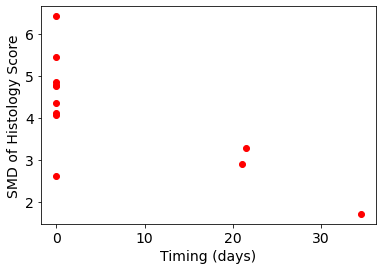

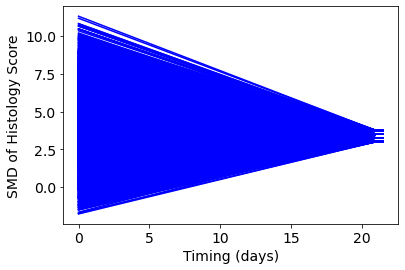

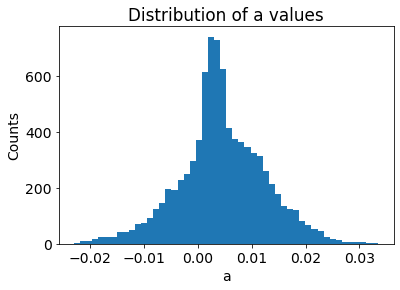

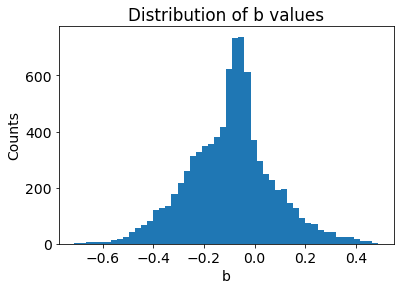

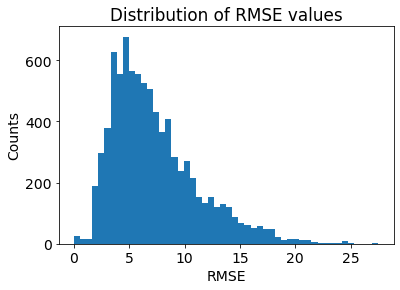

In [11]:
# Import packages into Python
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns 
import os
import random
import statsmodels.api as sm

#  Import data from CSV
dat = pd.read_csv('kneeOnly.csv', index_col = None)
df = pd.DataFrame(dat, columns= ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool'])
dat.columns = ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']
dataMat = dat.loc[:, ['PMID', 'Dosage', 'Timing','SMD', 'Sdpool']]
pmid = dataMat.PMID
dosage = dataMat.Dosage
timing = dataMat.Timing
SMD = dataMat.SMD
SDpool = dataMat.Sdpool


# Plot raw data
plt.rcParams.update({'font.size': 14});
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")
plt.plot(timing, SMD, 'ro')

# set up model
def dSMDdt(SMD, t, a, b):
    dSMDdt = a*t + b
    return dSMDdt

# define RMSE 
def RMSE(params):
    a, b = params;
    ODE_output = odeint(dSMDdt, SMD_0, timesteps, args = (a,b));
    err = ExpData -ODE_output
    SSE = np.sum(err**2)
    RMSE = np.sqrt(SSE)
    return RMSE



# Defines the size of the vector
sizeSMD = len(SMD)
# Defines the index size
index = 0
# Based on the size of the vector, and the number of 0 data points, figures out index size
for q in np.arange(0,sizeSMD,1):
    if timing[q] > 0:
        index = index + 1
index = index + 1

# Pulls time points based on timing data available 
startTime = sizeSMD - index-1
endTime = sizeSMD -1 
timesteps = timing[startTime:endTime]
# Sets initial guesses based on trendline model from Excel
p0 = [0.0004, -0.0756]
# sets counter equal to zero
f = 0
# Number of simulations to run
numIt = 20000
# Number of values to be generated for each data point
nVal = 100
# Generates a vector of the different values of a, b, and RMSE generated by the simulation
a = np.zeros(numIt) - 10000
b = np.zeros(numIt) - 10000
RMSE_val = np.zeros(numIt) - 10000
# Generates a random choice vector so that the starting point can be altered based on the data that are available
randChoiceEnd = startTime + 1
randChoice = np.arange(0,randChoiceEnd,1)
# generates a figure for the simulations to be plotted on
plt.figure() 
plt.xlabel("Timing (days)")
plt.ylabel("SMD of Histology Score")
plt.rcParams.update({'font.size': 14})

# Simulates using different initial conditions
for j in np.arange(1,numIt,1):
    # Generates ExpData vector
    ExpData = np.arange(0,index,1)
    # Choices a random value to start simulation with
    randVal = random.choice(randChoice)
    # Generates a normal distribution from the random starting point that was chosen 
    RandGen = np.random.normal(SMD[randVal], SDpool[randVal], nVal)
    # Randomly chooses a value from the normal distirbution of the random start point
    randCho = random.choice(RandGen)
    # Sets initial condition equal to chosen value
    SMD_0 = randCho
    ExpData[0] = SMD_0
    # Sets iteration markers
    m = randChoiceEnd
    q = 1
    
    for x in np.arange(1,index,1):
        # Generates a normal distribution based on the SMD and SD from that specific data point
        RandGen = np.random.normal(SMD[m], SDpool[m], nVal)
        # Randomly pulls a value from that normal distirbution to input into model
        randCho = random.choice(RandGen)
        # Assigns random value into experimental data
        ExpData[q] = randCho
        # Iterates m and q
        m = m + 1
        q = q + 1
    
    
    # Minimizes RMSE uses initial data
    sol = minimize(RMSE, p0);
    # Enters generated value into the vector to track all possible a and b values from simulation
    a_temp = sol.x[0]
    b_temp = sol.x[1]
    # Generates model data based on a and b values
    modelData = odeint(dSMDdt, SMD_0, timesteps, args = (a_temp,b_temp));
    # Checks to make sure model falls within range of data. 
    # If model is within the range of SMD+/-3*SD, it is kept and deemed an appropriate fit. (99% CI)
    # If the model is not within the 99% CI, it is considered an inappropriate fit and not kept
    
    # Sets counter = 0
    count = 0
    #Checks to see if model fits within boundary condition for the initial starting point that was randomly chosen above
    if modelData[0] <= (SMD[randVal]+3*SDpool[randVal]):
        if modelData[0] >= (SMD[randVal]-3*SDpool[randVal]):
            count = 1
    # If initial condition is okay, then it will loop through the maining data points to check to make sure each point meets the boundary condition
    for x in np.arange(1,len(modelData),1):
        if modelData[x] <= (SMD[startTime+x]+3*SDpool[startTime+x]):
            if modelData[x] >= (SMD[startTime+x]-3*SDpool[startTime+x]):
                count = count + 1
                        
    # If all points fit within the model parameter, then the value is recorded
    if count >= (len(modelData)):          
        # Stores a, b, and RMSE value 
        a[f] = a_temp;
        b[f] = b_temp;
        RMSE_val[f] = sol.fun
        # Increases counter
        f = f+1
        # Plots simulation
        plt.plot(timesteps, modelData, 'b-')
# saves figures
plt.savefig('timingSimModelsKnee.png', dpi=300, bbox_inches='tight');
# Keeps only the values of a, b, and RMSE where a value was added
j = 0
while a[j] > -10000:
    j = j +1
a_final = a[0:j]
b_final = b[0:j]
RMSE_final = RMSE_val[0:j]
    
# Plots generated a values
plt.subplots()
plt.hist(a_final, bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of a values")
plt.xlabel("a")
plt.ylabel("Counts")
plt.savefig('timingSimAValueKnee.png', dpi=300, bbox_inches='tight');

# Plots generated b values
plt.subplots()
plt.hist(b_final,bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of b values")
plt.xlabel("b")
plt.ylabel("Counts")
plt.savefig('timingSimBValueKnee.png', dpi=300, bbox_inches='tight');

# Plots generated RMSE values
plt.subplots()
plt.hist(RMSE_final,bins = 50);
plt.rcParams.update({'font.size': 14})
plt.title(f"Distribution of RMSE values")
plt.xlabel("RMSE")
plt.ylabel("Counts")
plt.savefig('timingSimRMSEValueKnee.png', dpi=300, bbox_inches='tight');


# Calculate the p value for a 
f = 0
n = 0
sizeA = len(a_final)-1
for j in np.arange(1,sizeA,1):
    if a_final[f] >= 0:
        n = n +1
    f = f+1

a_pvalue = (sizeA-n)/sizeA

# Calculate p value for b
g = 0
m= 0
sizeB = len(b_final)-1
for k in np.arange(1,sizeB,1):
    if b_final[g] >= 0:
        m = m+1
    g = g+1
    
b_pvalue =(m)/sizeB

# Print both p values
print('The p-value for the a parameter is %.4f.' % a_pvalue)
print('The p-value for the b parameter is %.4f.' % b_pvalue)
# Print the average value for both paramters
a_avg = sum(a_final)/len(a_final)
b_avg = sum(b_final)/len(b_final)
print('The average value for the a parameter is %.4f.' % a_avg)
print('The average value for the b parameter is %.4f.' % b_avg)
